In [ ]:
# Importações
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import librosa
import librosa.display
from IPython.display import Audio
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from pydub import AudioSegment
from scipy.io.wavfile import write

In [2]:
DATA_PATH = 'data/google' # Define o caminho do diretório onde estão armazenados os dados

# Definindo o valor da semente para a reprodutibilidade do experimento, isso garante que os resultados do experimento sejam consistentes e reproduzíveis
seed = 42
tf.random.set_seed(seed) # Para definir a semente de geração de números aleatórios, utilizando o TensorFlow
np.random.seed(seed) # Para definir a semente de geração de números aleatórios, utilizando o NumPy

In [3]:
audio_array,sr = librosa.load("data/gravacao_audio.wav") # Carrega o arquivo de áudio
audio_array.shape # Exibe uma matriz de duaz dimensões que contém os valores de amostra do áudio, representando a quantidade de canais de áudio e os pontos no tempo

(22050,)

A variável sr armazena a taxa de amostragem do áudio, que é a quantidade de vezes que o sinal de áudio é amostrado por segundo

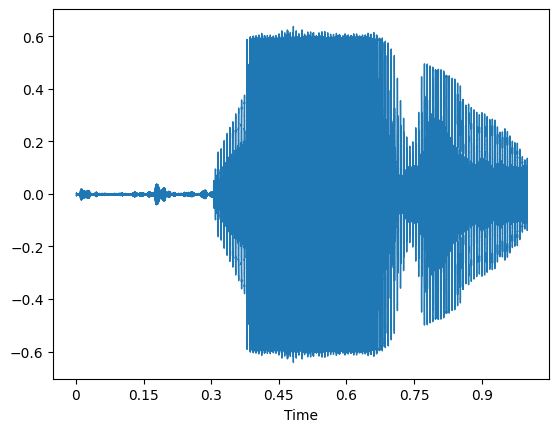

In [4]:
librosa.display.waveshow(audio_array, sr=sr) # Exibe um gráfico de ondas de um arquivo de áudio, mostrando a altura do sinal de áudio em cada ponto no tempo

In [19]:
x = 'data/gravacao_audio.wav' # Exemplo escolhido de caminho do arquivo de áudio

x = tf.io.read_file(str(x)) # Lê o arquivo de áudio
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,) # Decodifica o arquivo de áudio, retornando um tensor com as amostras de áudio e a taxa de amostragem
x = tf.squeeze(x, axis=-1) # Remove o eixo -1 do tensor
waveform = x # Atribução do tensor de amostras de áudio
display.display(display.Audio(waveform, rate=16000)) # Exibe um gráfico de ondas do áudio

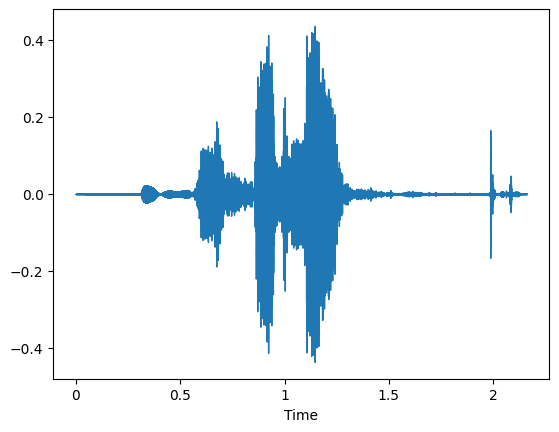

In [20]:
audio_2,sr = librosa.load("data/example.mp3")
librosa.display.waveshow(audio_2, sr=sr)

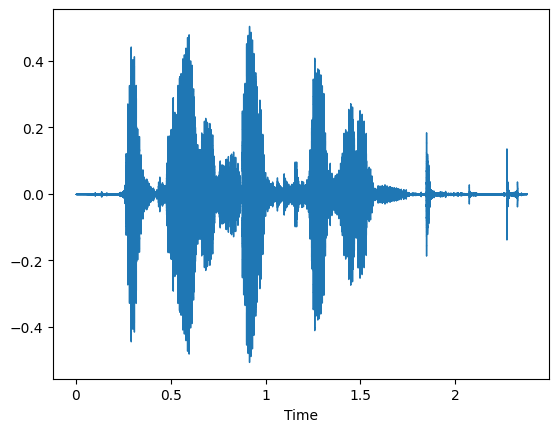

In [21]:
audio_3,sr = librosa.load("data/sentence.mp3")
librosa.display.waveshow(audio_3, sr=sr)

# Starting

In [22]:
data_dir = pathlib.Path(DATA_PATH) # Cria um objeto pathlib.Path para representar o diretório
commands = np.array(tf.io.gfile.listdir(str(data_dir))) # Extraindo do diretório data o nome dos arquivos que significam as palavras disponíveis
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != '.txt') & (commands != 'testing_list.txt') & (commands != 'validation_list.txt') & (commands != 'LICENSE')] # Filtra os arquivos que não são relevantes para o nosso caso de uso
print('Commands:', commands) # Imprime os comandos disponíveis

Commands: ['background' 'eden' 'marvin' 'off' 'on' '_background_noise_']


In [23]:
# Cria um conjunto de dados de áudio a partir de um diretório, divide-o em treinamento e validação
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,  # O caminho do diretório onde estão armazenados os arquivos de áudio
    batch_size=64, # A quantidade de amostras de áudio processadas em cada etapa de treinamento
    validation_split=0.2, # A porcentagem do conjunto de dados que será utilizada para validação
    seed=0, # A semente para a geração de números aleatórios
    output_sequence_length=16000, # O comprimento da sequência de saída das amostras de áudio
    subset='both') # O conjunto de dados será dividido em treinamento e validação

label_names = np.array(train_ds.class_names) # Extrai os nomes das classes (ou rótulos) presentes no conjunto de dados de treinamento
print()
print("label names:", label_names) # Imprime os nomes das classes

Found 12406 files belonging to 6 classes.
Using 9925 files for training.
Using 2481 files for validation.

label names: ['_background_noise_' 'background' 'eden' 'marvin' 'off' 'on']


In [24]:
train_ds.element_spec # Informações da estrutura dos dados de entrada e saída para o conjunto de dados de treinamento

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

 É representado por um par de tensores, o primeiro tensor da estrutura dos dados de entrada, que representa uma sequência de números reais (float32) de 16000 elementos e cada elemento pode ter qualquer tamanho (None), o segundo tensor da estrutura dos dados de saída, que representa uma sequência de números inteiros (int32) que podem ter qualquer tamanho (None)

In [25]:
# Função que remove o último eixo do tensor de áudio
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

# É feito um mapeamento aplicando a função squeeze, onde o TensorFlow ajusta automaticamente a taxa de processamento de acordo com a capacidade do sistema
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

É útil para simplificar a estrutura dos dados e facilitar a manipulação e processamento subsequentes, resultando em um tensor com menos dimensões

In [26]:
# Dividindo o conjunto de validação em dois conjuntos de validação menores *
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [27]:
for example_audio, example_labels in train_ds.take(1): # Utilizamos a função take para obter apenas um exemplo do conjunto de dados de treinamento
  print(example_audio.shape) # Imprimimos a forma do exemplo de áudio
  print(example_labels.shape) # Imprimimos a forma do exemplo de rótulos

(64, 16000)
(64,)


In [28]:
label_names[[0,1,2,3,4,5]] # Obtem os nomes das classes

array(['_background_noise_', 'background', 'eden', 'marvin', 'off', 'on'],
      dtype='<U18')

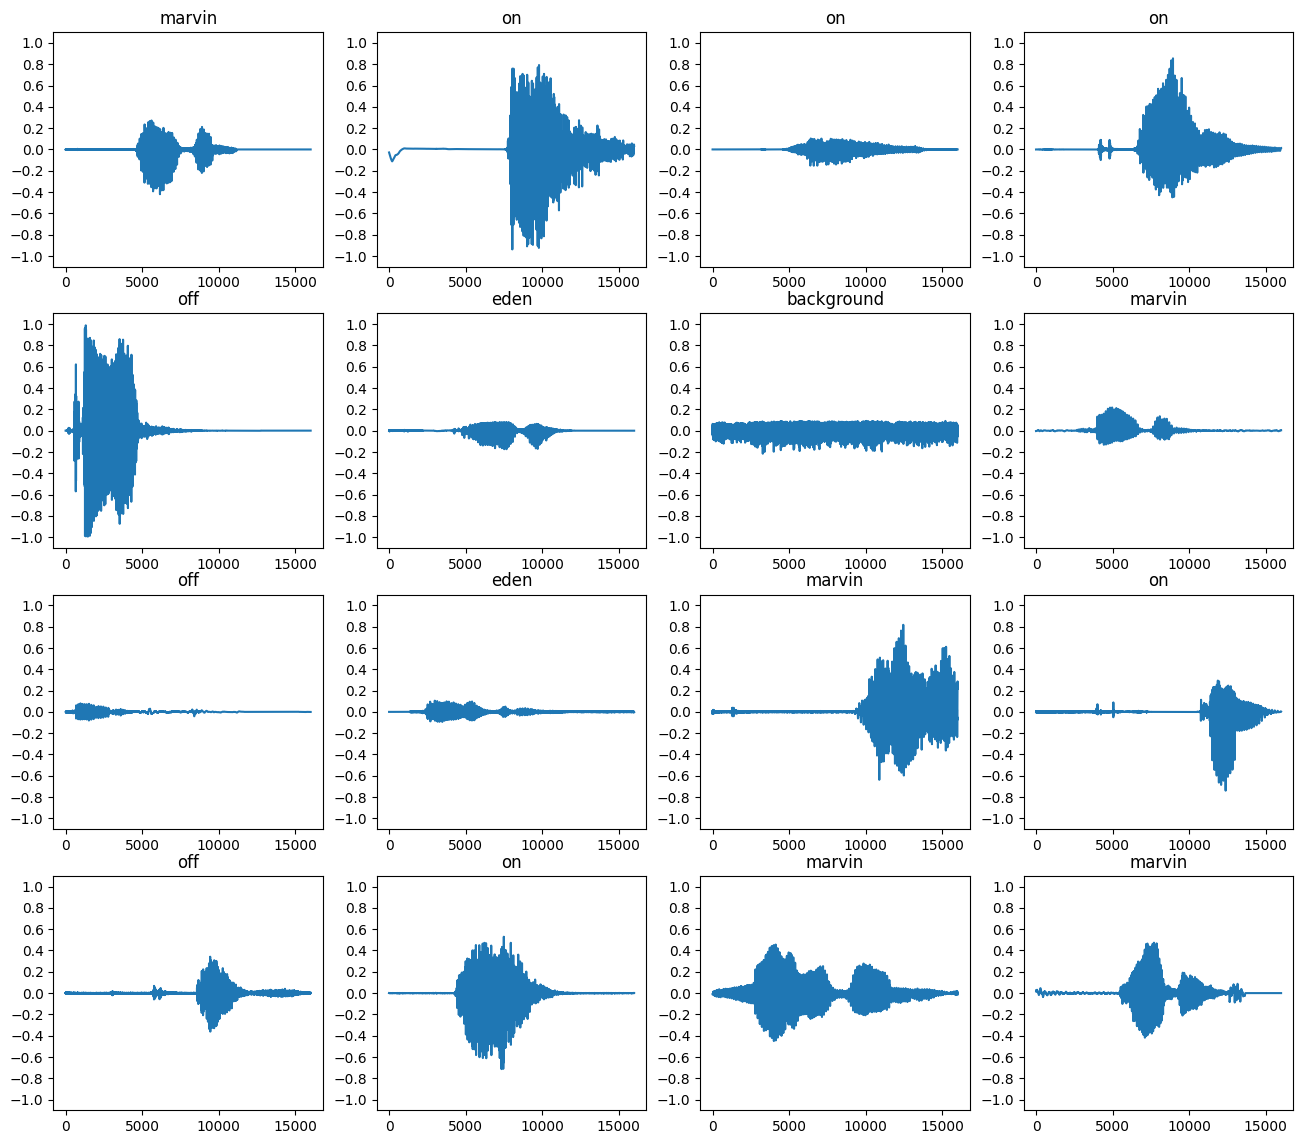

In [53]:
# Exibe um gráfico de ondas que representa os dados de áudio de cada classe de áudio
plt.figure(figsize=(16, 14))
rows = 4
cols = 4
n = rows * cols
for i in range(n): # Itera sobre os dados de áudio, onde cada item de dados de áudio é uma série temporal de amostras de áudio
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [30]:
# Identifica a classe de áudio de um sinal de áudio fornecido
def get_spectrogram(waveform): # Aceita um sinal de áudio como entrada
  spectrogram = tf.signal.stft( # Calcula a transformada de Fourier espectral do sinal de áudio,  permitindo visualizar a frequência de cada ponto no tempo do sinal de áudio
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram) # Calculo do valor absoluto de cada ponto no espectrograma, devido ao efeito do "cuerno de açúcar" no espectrograma

  spectrogram = spectrogram[..., tf.newaxis] # Um novo eixo é adicionado ao espectrograma para que ele tenha a mesma estrutura que os espectrogramas de outras classes de áudio
  return spectrogram # Retorna uma representação gráfica espectral do sinal de áudio

In [31]:
for i in range(3):
  label = label_names[example_labels[i]] # Obtenção do rótulo do exemplo atual de áudio
  waveform = example_audio[i] # Obtenção do sinal de áudio
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000)) # Reprodução do áudio

Label: marvin
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: on
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: on
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [32]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps) # Converte as frequências do espectrograma para uma escala logarítmica e transpoe a matriz, adiciona um epsilon para evitar a divisão por zero
  # Obtendo a matriz de frequências logarítmicas
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int) # Contem os valores equidistantes entre 0 e o tamanho do objeto spectrogram
  Y = range(height) # Gera uma sequência de números inteiros de 0 a a height - 1
  ax.pcolormesh(X, Y, log_spec) # Desenha um gráfico de intensidade de cor (colormap) na matriz de frequências logarítmicas

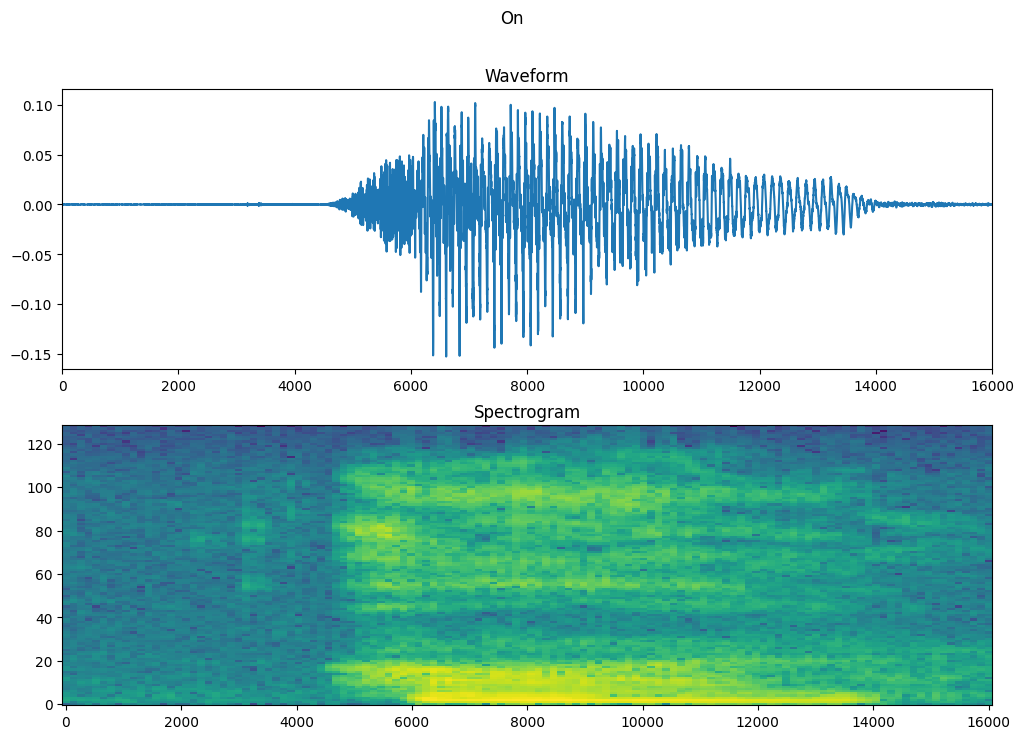

In [33]:
# Exibe um gráfico de ondas no topo e um espectrograma na parte inferior
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [34]:
# Transforma um dataset de sinais de áudio em um dataset de espectrogramas com seus respectivos rótulos
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [35]:
# Transforma os conjuntos em espectrogramas
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [36]:
# Um exemplo de como os dados são divididos e processados em espectrogramas
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1): # Extrai apenas o primeiro exemplo de cada lote
  break # Interrompe o loop assim que a extração é feita

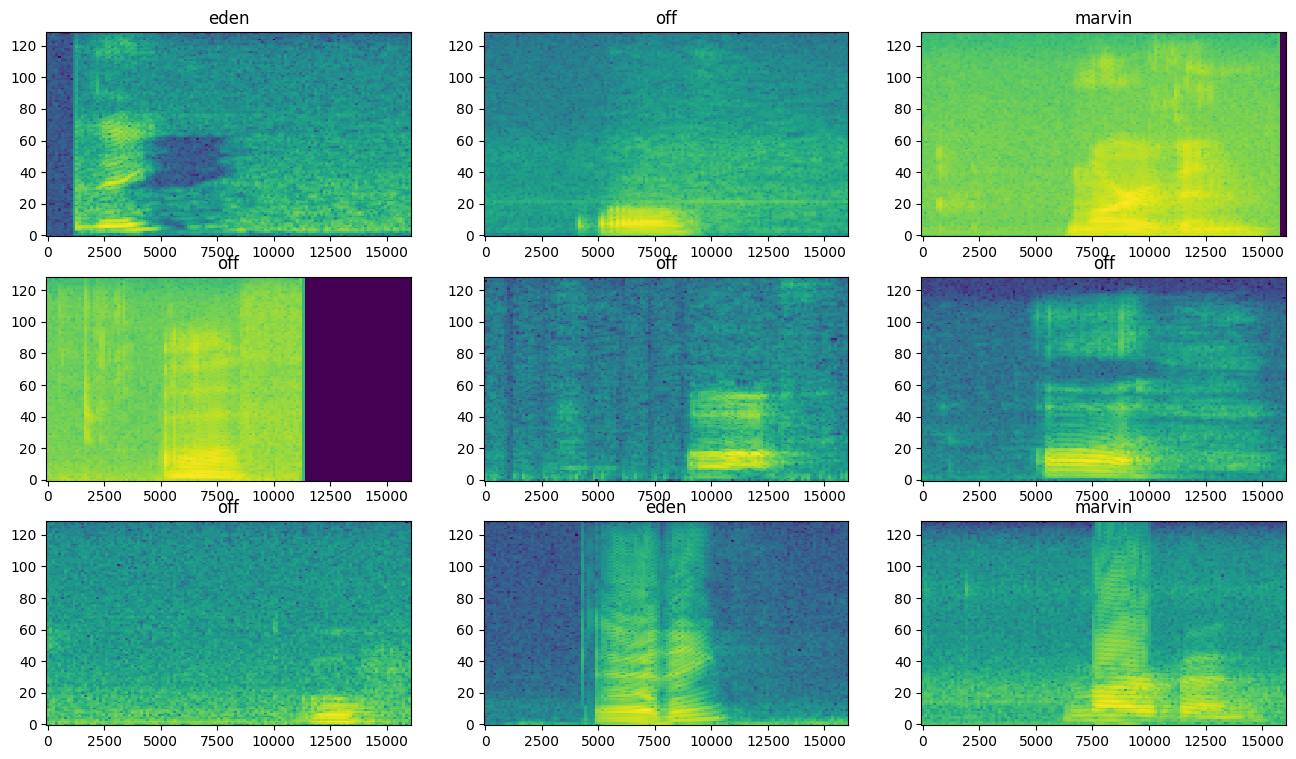

In [37]:
# Comparação das características dos sinais representados pelo espectrograma
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [38]:
# Armazena em cache os elementos gerados pelos conjuntos de dados, além de embaralhar os elementos do conjunto de dados e precarrega os próximos elementos dos conjuntos de dados enquanto o treinamento está em andamento, afim de melhorar a peformance
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [39]:
input_shape = example_spectrograms.shape[1:] # Forma de entrada
print('Input shape:', input_shape)
num_labels = len(label_names) # Número de rótulos

# Normalização
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

# Criação do modelo em camadas
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32), # Redimensiona a imagem (pixels)
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'), # Etapa de convolução, afim de extrair recursos locais dos espectrogramas
    layers.Conv2D(64, 3, activation='relu'), # Etapa de convolução, afim de extrair recursos locais dos espectrogramas
    layers.MaxPooling2D(), # Reduz a resolução espacial do espectrograma
    layers.Dropout(0.25), # Reduzindo a probabilidade de overfitting
    layers.Flatten(), # Converte o formato de dados em uma matriz unidimensional
    layers.Dense(128, activation='relu'), # Modela as relações entre os recursos extraídos
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary() # Imprime um resumo detalhado do modelo

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [40]:
# Compila o modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'], # Métrica de avaliação usada durante o treinamento
)

In [41]:
# Treina o modelo
EPOCHS = 12 # Quantas vezes o modelo será treinado no conjunto de dados de treinamento
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2), # O treinamento será interrompido após duas EPOCHS consecutivos sem melhorar o desempenho
)

Epoch 1/12


156/156 [==============================] - 6s 37ms/step - loss: 0.9517 - accuracy: 0.6212 - val_loss: 0.6349 - val_accuracy: 0.7780
Epoch 2/12
156/156 [==============================] - 6s 36ms/step - loss: 0.5995 - accuracy: 0.7720 - val_loss: 0.4634 - val_accuracy: 0.8421
Epoch 3/12
156/156 [==============================] - 5s 35ms/step - loss: 0.4559 - accuracy: 0.8351 - val_loss: 0.3631 - val_accuracy: 0.8709
Epoch 4/12
156/156 [==============================] - 5s 35ms/step - loss: 0.3537 - accuracy: 0.8764 - val_loss: 0.2814 - val_accuracy: 0.9071
Epoch 5/12
156/156 [==============================] - 5s 34ms/step - loss: 0.2935 - accuracy: 0.8995 - val_loss: 0.2271 - val_accuracy: 0.9276
Epoch 6/12
156/156 [==============================] - 5s 35ms/step - loss: 0.2405 - accuracy: 0.9172 - val_loss: 0.2037 - val_accuracy: 0.9309
Epoch 7/12
156/156 [==============================] - 5s 34ms/step - loss: 0.2115 - accuracy: 0.9283 - val_loss: 0.1780 - val_accuracy: 0.9391
Epoch 8/12

Text(0, 0.5, 'Accuracy [%]')

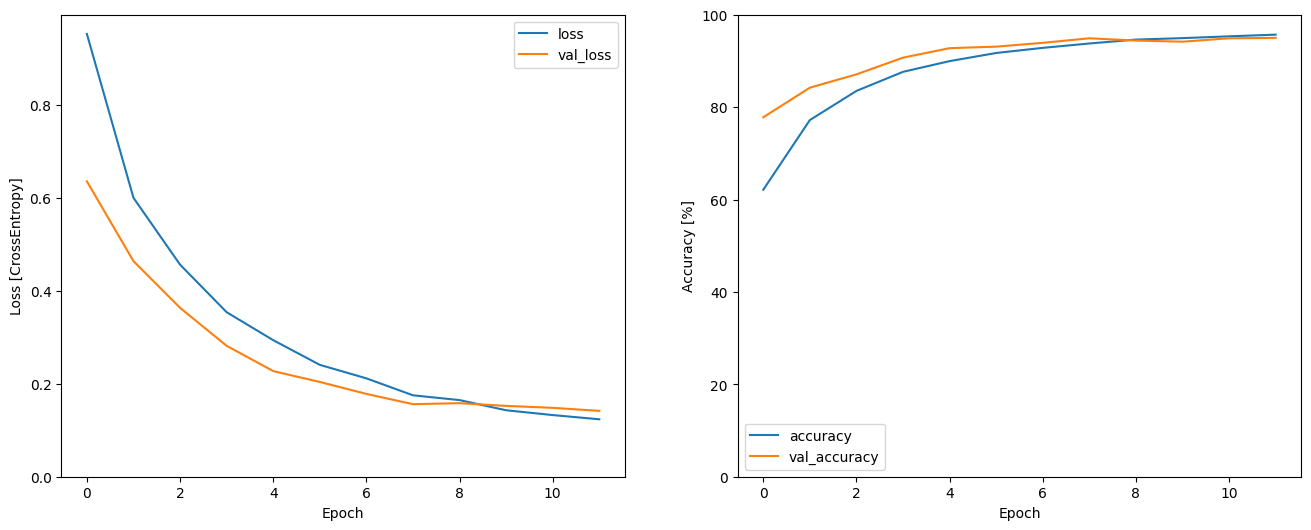

In [42]:
# Plota dois gráficos para monitorar a evolução do desempenho do modelo durante o treinamento
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss']) # Mede o quão longe as previsões do modelo estão das rótulos reais
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy']) # Mede a proporção de previsões corretas
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [43]:
model.evaluate(test_spectrogram_ds, return_dict=True) # Valor da métrica de avaliação do modelo

20/20 [==============================] - 0s 18ms/step - loss: 0.2405 - accuracy: 0.9391


{'loss': 0.2405180037021637, 'accuracy': 0.939130425453186}

In [44]:
y_pred = model.predict(test_spectrogram_ds) # Realiza a predição

20/20 [==============================] - 0s 7ms/step


In [45]:
y_pred = tf.argmax(y_pred, axis=1) # Converte as probabilidades previstas para a classe real, contendo o índice da classe prevista para cada amostra

In [46]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0) # Criando um único tensor 1D que contém todos os rótulos dos espectrogramas de teste

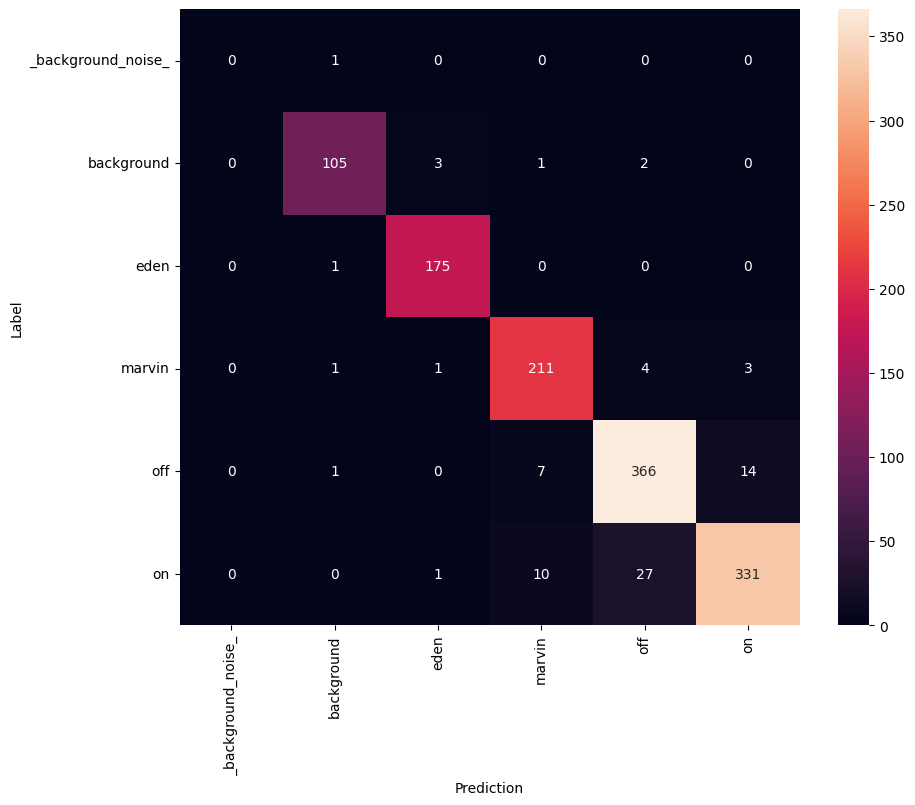

In [47]:
# Exibe uma matriz de confusão que diz as ocorrências dos rótulos verdadeiros vesus as previsões do modelo
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

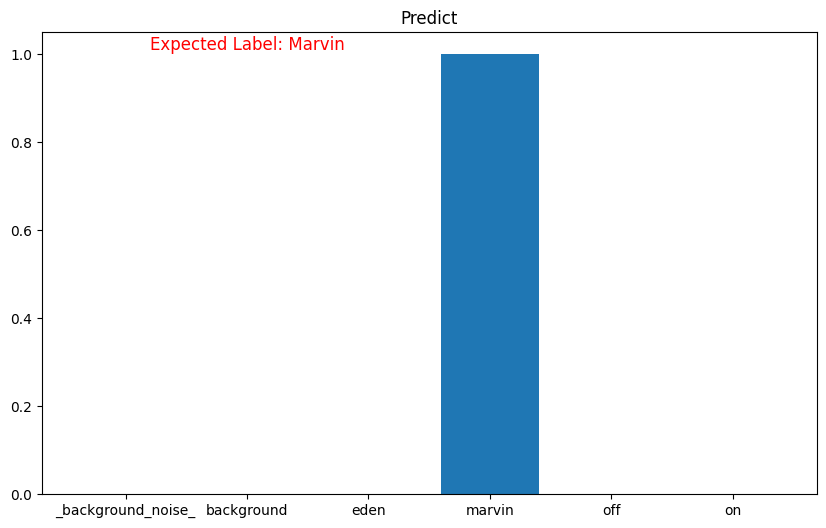

In [60]:
plt.figure(figsize=(10, 6))
plt.text(1, 1, 'Expected Label: Marvin', fontsize=12, ha='center', va='bottom', color='r')

x = 'data/gravacao_audio.wav' # Carrega um arquivo de áudio de exemplo

# Normaliza o sinal de áudio e redimensiona para corresponder ao formato esperado pelo modelo
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x) # Obtém a previsão do modelo
x_labels = label_names[[0,1,2,3,4,5]]

# Exibe um gráfico de barras com base na probabilidade de previsão do modelo
plt.bar(x_labels, tf.nn.softmax(prediction[0])) 
plt.title('Predict')
plt.show()

display.display(display.Audio(waveform, rate=16000)) # Exibe o áudio carregado

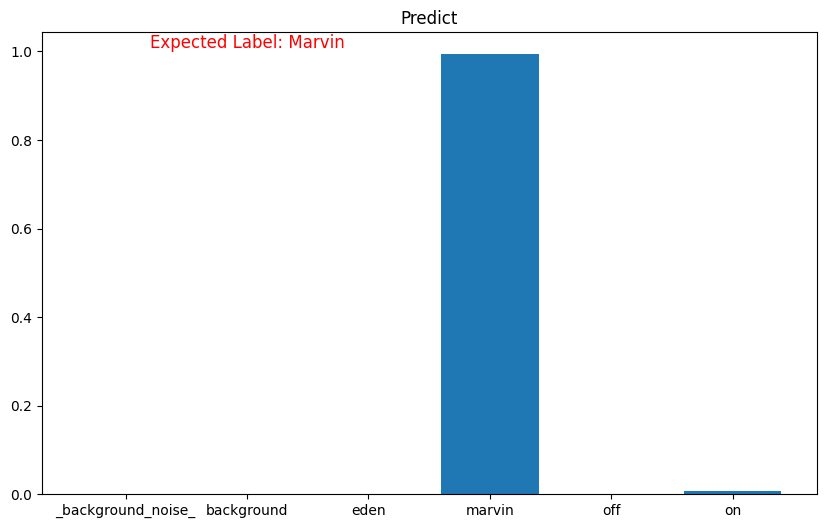

In [59]:
plt.figure(figsize=(10, 6))
plt.text(1, 1, 'Expected Label: Marvin', fontsize=12, ha='center', va='bottom', color='r')
# Example file
x = 'audios\marvin\Gh6jPiT2mRgravacao_audio.wav'

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names[[0,1,2,3,4,5]]
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predict')
plt.show()

display.display(display.Audio(waveform, rate=16000))

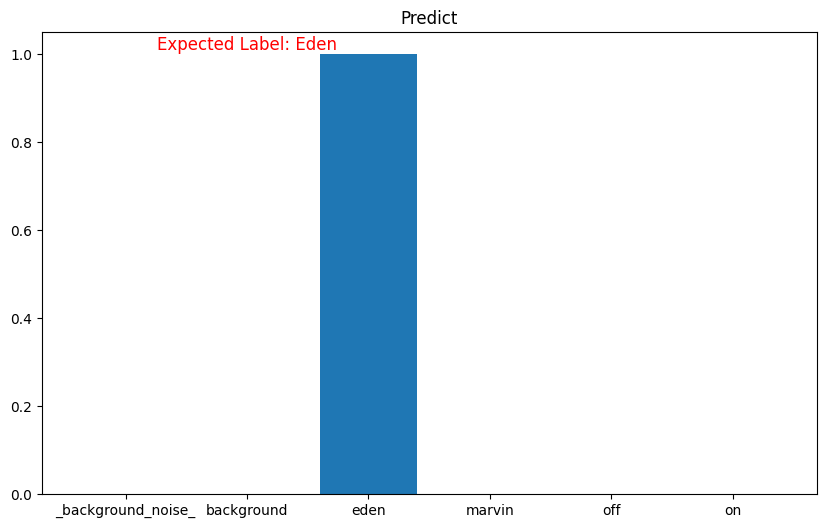

In [58]:
plt.figure(figsize=(10, 6))

plt.text(1, 1, 'Expected Label: Eden', fontsize=12, ha='center', va='bottom', color='r')
# Example file
x = 'audios/eden/1bnZDdOdsK.wav'

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names[[0,1,2,3,4,5]]
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predict')
plt.show()

display.display(display.Audio(waveform, rate=16000))

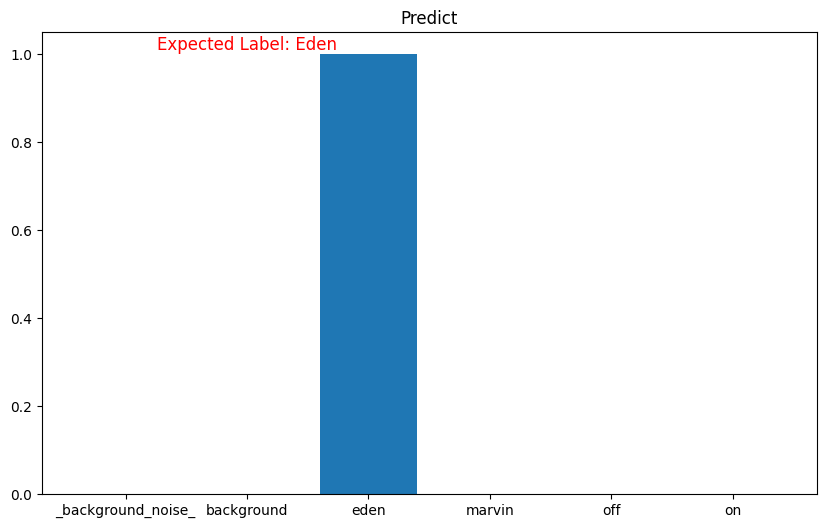

In [61]:
plt.figure(figsize=(10, 6))

plt.text(1, 1, 'Expected Label: Eden', fontsize=12, ha='center', va='bottom', color='r')
# Example file
x = 'audios/eden/0449l0a7gH.wav'

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names[[0,1,2,3,4,5]]
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predict')
plt.show()

display.display(display.Audio(waveform, rate=16000))

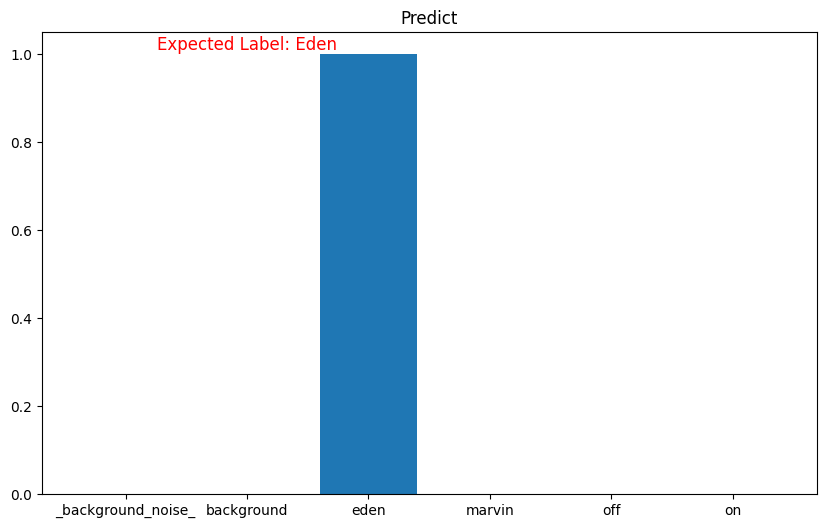

In [62]:
plt.figure(figsize=(10, 6))

plt.text(1, 1, 'Expected Label: Eden', fontsize=12, ha='center', va='bottom', color='r')
# Example file
x = 'test/eden/1C0bheEchT.wav'

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names[[0,1,2,3,4,5]]
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predict')
plt.show()

display.display(display.Audio(waveform, rate=16000))

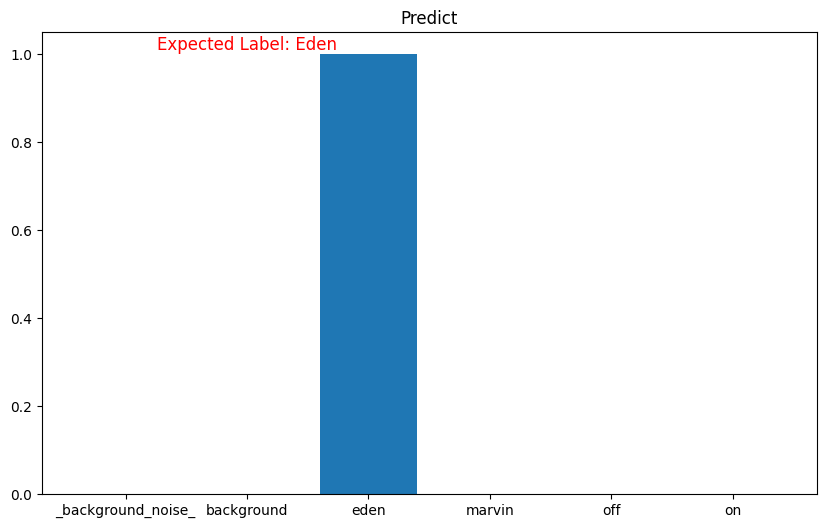

In [63]:
plt.figure(figsize=(10, 6))

plt.text(1, 1, 'Expected Label: Eden', fontsize=12, ha='center', va='bottom', color='r')
# Example file
x = 'test/eden/0Vxf4z4Fbc.wav'

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names[[0,1,2,3,4,5]]
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predict')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [66]:
model.save("model/saved")

INFO:tensorflow:Assets written to: model/saved\assets


INFO:tensorflow:Assets written to: model/saved\assets
